# League Position Prediction - English Premier League
**Important: Run cells sequentially from top to bottom (Shift+Enter or Run All). Each cell depends on variables created by previous cells.**

This notebook predicts the final league standings for the EPL season based on Monte Carlo simulations.

## 1. Setup and Configuration

In [1]:
# Import required libraries
import sys
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add parent directory to path so we can import src module
sys.path.insert(0, "..")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 10)

### Load Configuration

Import the configuration file for your league. Configuration files are stored in the `configs/` directory.

In [2]:
# Load configuration for the league
config_file = "../configs/epl.yaml"  # Change this to use a different league

with open(config_file, "r") as f:
    config = yaml.safe_load(f)

print(f"League: {config['league']['name']}")
print(f"Country: {config['league']['country']}")
print(f"Season: {config['league']['current_season']}")

League: English Premier League
Country: England
Season: 2025


## 2. Data Loading and Preparation

Load and prepare match data from the configured sources.

In [3]:
# Import data loading and preprocessing modules
from src.data import (
    load_fixture_csv,
    load_match_statistics,
    normalize_team_names,
    prepare_match_statistics,
)
from src.preprocessing import (
    calculate_home_team_statistics,
    calculate_away_team_statistics,
    calculate_efficiency_metrics,
    calculate_league_table,
)
from src.preprocessing.utils import (
    create_played_matches_dataframe,
    create_remaining_matches_dataframe,
)

# Load fixtures data
fixtures_path = f"../data/raw/{config['data_sources']['all_matches']['filename']}"
fixtures = load_fixture_csv(fixtures_path)

# Normalize team names based on configuration
fixtures = normalize_team_names(fixtures, config.get("team_name_mapping", {}))

print(f"Loaded {len(fixtures)} fixtures")
print(f"Fixtures shape: {fixtures.shape}")
print(f"\nFirst 5 fixtures:")
print(fixtures.head())

Loaded 380 fixtures
Fixtures shape: (380, 7)

First 5 fixtures:
   Match Number  Round Number              Date                   Location  \
0             1             1  15/08/2025 20:00                    Anfield   
1             2             1  16/08/2025 12:30                 Villa Park   
2             3             1  16/08/2025 15:00   American Express Stadium   
3             5             1  16/08/2025 15:00           Stadium of Light   
4             6             1  16/08/2025 15:00  Tottenham Hotspur Stadium   

     Home Team    Away Team Result  
0    Liverpool  Bournemouth  4 - 2  
1  Aston Villa    Newcastle  0 - 0  
2     Brighton       Fulham  1 - 1  
3   Sunderland     West Ham  3 - 0  
4        Spurs      Burnley  3 - 0  


In [4]:
# Load match statistics
stats_path = f"../data/raw/{config['data_sources']['match_statistics']['filename']}"
statistics = load_match_statistics(stats_path)

# Prepare statistics: standardize columns and normalize team names
statistics = prepare_match_statistics(statistics, config)

print(f"Loaded {len(statistics)} match results")
print(f"Statistics shape: {statistics.shape}")
print(f"\nFirst 5 matches:")
print(statistics.head())

Loaded 240 match results
Statistics shape: (240, 10)

First 5 matches:
         Date    Home Team    Away Team  Home Goals  Away Goals Result  \
0  15/08/2025    Liverpool  Bournemouth           4           2      H   
1  16/08/2025  Aston Villa    Newcastle           0           0      D   
2  16/08/2025     Brighton       Fulham           1           1      D   
3  16/08/2025   Sunderland     West Ham           3           0      H   
4  16/08/2025        Spurs      Burnley           3           0      H   

   Home Shots  Away Shots  Home Shots on Target  Away Shots on Target  
0          19          10                    10                     3  
1           3          16                     3                     3  
2          10           7                     4                     2  
3          10          12                     5                     4  
4          16          14                     6                     4  


In [5]:
# Separate played and remaining matches
played_matches = create_played_matches_dataframe(statistics)
remaining_matches = create_remaining_matches_dataframe(fixtures)

print(f"Played matches: {len(played_matches)}")
print(f"Remaining matches: {len(remaining_matches)}")
print(f"\nRemaining matches sample:")
print(remaining_matches.head())

Played matches: 240
Remaining matches: 140

Remaining matches sample:
     Home Team      Away Team
0        Leeds  Nott'm Forest
1      Man Utd          Spurs
2      Arsenal     Sunderland
3  Bournemouth    Aston Villa
4      Burnley       West Ham


## 3. Team Statistics Analysis

Calculate statistics for each team in their home and away performances.

In [6]:
# Calculate home and away team statistics
home_stats = calculate_home_team_statistics(statistics)
away_stats = calculate_away_team_statistics(statistics)

# Calculate efficiency metrics
home_stats, away_stats = calculate_efficiency_metrics(home_stats, away_stats)

print("Home Team Statistics (sorted by attacking efficiency):")
print(
    home_stats.sort_values("home_attack_eff", ascending=False)[
        [
            "avg_home_goals_scored",
            "home_attack_eff",
            "home_defense_eff",
            "home_chance_creation_eff",
            "home_chance_suppression_eff",
        ]
    ].head(10)
)

Home Team Statistics (sorted by attacking efficiency):
             avg_home_goals_scored  home_attack_eff  home_defense_eff  \
Home Team                                                               
Brentford                 1.916667         0.170370          0.079470   
Sunderland                1.750000         0.162791          0.065217   
Man City                  2.416667         0.151042          0.078431   
Arsenal                   2.333333         0.143590          0.109589   
Fulham                    1.750000         0.135484          0.112903   
Newcastle                 1.833333         0.128655          0.125000   
West Ham                  1.333333         0.124031          0.161491   
Bournemouth               1.583333         0.117284          0.117117   
Brighton                  1.666667         0.116279          0.103175   
Chelsea                   1.666667         0.116279          0.097744   

             home_chance_creation_eff  home_chance_suppression_eff  

In [7]:
print("\nAway Team Statistics (sorted by attacking efficiency):")
print(
    away_stats.sort_values("away_attack_eff", ascending=False)[
        [
            "avg_away_goals_scored",
            "away_attack_eff",
            "away_defense_eff",
            "away_chance_creation_eff",
            "away_chance_suppression_eff",
        ]
    ].head(10)
)


Away Team Statistics (sorted by attacking efficiency):
                avg_away_goals_scored  away_attack_eff  away_defense_eff  \
Away Team                                                                  
Spurs                        1.666667         0.165289          0.113333   
Chelsea                      1.833333         0.146667          0.102190   
Man City                     1.666667         0.136054          0.120000   
Burnley                      1.083333         0.134021          0.138889   
Bournemouth                  1.750000         0.131250          0.152284   
Liverpool                    1.583333         0.123377          0.155556   
Aston Villa                  1.416667         0.121429          0.094118   
Brentford                    1.083333         0.116071          0.130719   
Man Utd                      1.750000         0.115385          0.140940   
Crystal Palace               1.166667         0.114754          0.093960   

                away_chance_cre

## 4. Current League Table

Show the current league standings before simulation.

In [8]:
# Calculate current league table
current_league_table = calculate_league_table(played_matches)

print(
    f"Current League Table (after {current_league_table['Played'].head(1).values[0]} matches played):\n"
)
print(
    current_league_table[
        [
            "Position",
            "Team",
            "Played",
            "Wins",
            "Draws",
            "Losses",
            "Goals For",
            "Goals Against",
            "Goal Difference",
            "Points",
        ]
    ].to_string(index=False)
)

Current League Table (after 24 matches played):

 Position           Team  Played  Wins  Draws  Losses  Goals For  Goals Against  Goal Difference  Points
        1        Arsenal      24    16      5       3         46             17               29      53
        2       Man City      24    14      5       5         49             23               26      47
        3    Aston Villa      24    14      4       6         35             26                9      46
        4        Man Utd      24    11      8       5         44             36                8      41
        5        Chelsea      24    11      7       6         42             27               15      40
        6      Liverpool      24    11      6       7         39             33                6      39
        7      Brentford      24    11      3      10         36             32                4      36
        8     Sunderland      24     9      9       6         27             26                1      36
      

## 5. Monte Carlo Simulation

Run Monte Carlo simulations to predict final league table positions.

In [9]:
# Import Monte Carlo simulation functions
from src.modelling import (
    monte_carlo_simulation,
    calculate_position_probabilities,
    get_team_final_position_stats,
)

# Run Monte Carlo simulation
n_simulations = config["simulation"]["n_simulations"]
random_seed = config["simulation"]["random_seed"]

print(f"Running {n_simulations} Monte Carlo simulations...")

league_tables_sim, full_season_results_sim = monte_carlo_simulation(
    fixtures,
    played_matches,
    home_stats,
    away_stats,
    n_simulations=n_simulations,
    random_seed=random_seed,
)

print(f"Completed {len(league_tables_sim)} simulations")

Running 1000 Monte Carlo simulations...
Completed 1000 simulations


In [10]:
# Calculate position probabilities
position_probs = calculate_position_probabilities(
    league_tables_sim, current_league_table
)

print("\nFinal Position Probabilities:")
print(position_probs)


Final Position Probabilities:
                   1      2      3      4      5      6      7      8      9   \
Arsenal         0.897  0.096  0.006  0.001  0.000  0.000  0.000  0.000  0.000   
Man City        0.094  0.605  0.240  0.050  0.010  0.001  0.000  0.000  0.000   
Aston Villa     0.009  0.243  0.474  0.195  0.068  0.010  0.001  0.000  0.000   
Man Utd         0.000  0.027  0.141  0.290  0.256  0.169  0.067  0.027  0.017   
Chelsea         0.000  0.023  0.090  0.264  0.312  0.184  0.075  0.033  0.007   
Liverpool       0.000  0.006  0.036  0.134  0.196  0.287  0.171  0.088  0.045   
Brentford       0.000  0.000  0.005  0.019  0.045  0.107  0.185  0.205  0.156   
Sunderland      0.000  0.000  0.004  0.024  0.052  0.094  0.178  0.173  0.157   
Fulham          0.000  0.000  0.001  0.008  0.017  0.036  0.097  0.111  0.136   
Everton         0.000  0.000  0.001  0.006  0.014  0.033  0.061  0.103  0.165   
Newcastle       0.000  0.000  0.001  0.003  0.018  0.037  0.073  0.120  0.127 

## 6. Visualization of Results

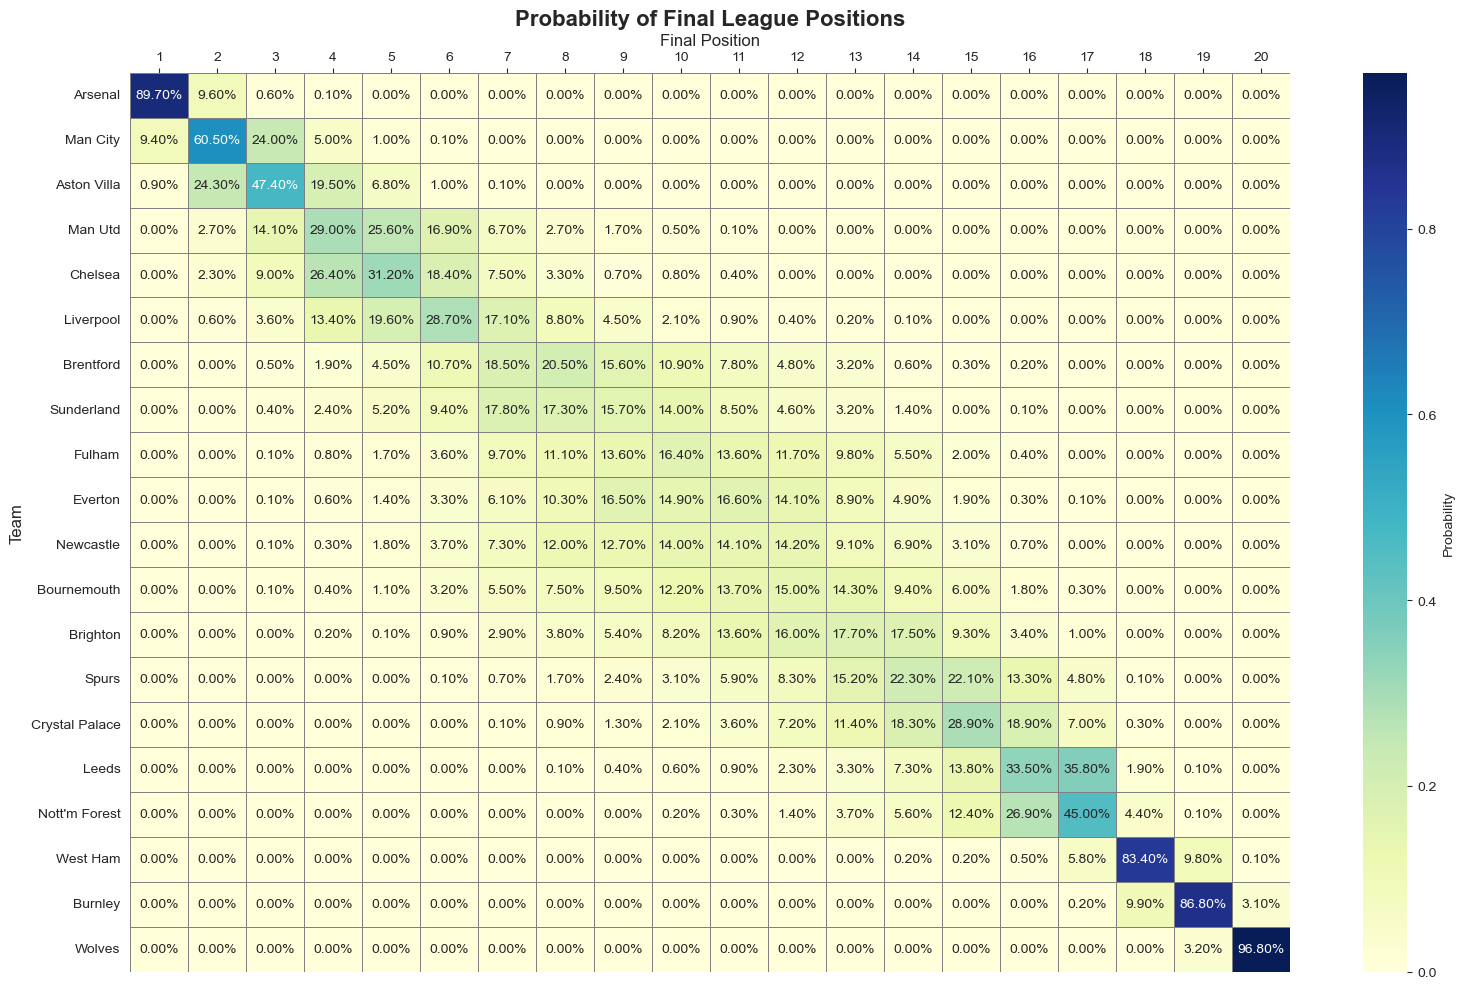

In [11]:
# Import visualization functions
from src.visualization import (
    plot_position_probabilities_heatmap,
    plot_team_position_distribution,
    plot_multiple_teams_distribution,
)

# Create heatmap visualization
plot_position_probabilities_heatmap(position_probs)

## 7. Detailed Team Analysis

Generate detailed statistics for each team's expected final position.

In [12]:
# Generate team statistics report
team_names = current_league_table["Team"].tolist()
team_stats_report = {}

for team in team_names:
    team_stats_report[team] = get_team_final_position_stats(position_probs, team)

# Create a DataFrame for better visualization
stats_df = pd.DataFrame(team_stats_report).T
stats_df = stats_df.sort_values("most_likely_position")

print("Team Final Position Statistics:\n")
print(stats_df)

Team Final Position Statistics:

                most_likely_position  most_likely_prob  mean_position  \
Arsenal                          1.0             0.897           1.11   
Man City                         2.0             0.605           2.28   
Aston Villa                      3.0             0.474           3.10   
Man Utd                          4.0             0.290           4.83   
Chelsea                          5.0             0.312           5.01   
Liverpool                        6.0             0.287           6.06   
Sunderland                       7.0             0.178           8.49   
Brentford                        8.0             0.205           8.40   
Fulham                          10.0             0.164          10.07   
Everton                         11.0             0.166          10.23   
Newcastle                       12.0             0.142          10.32   
Bournemouth                     12.0             0.150          11.05   
Brighton          

## 8. Top Teams Analysis

Compare position distributions for top teams.

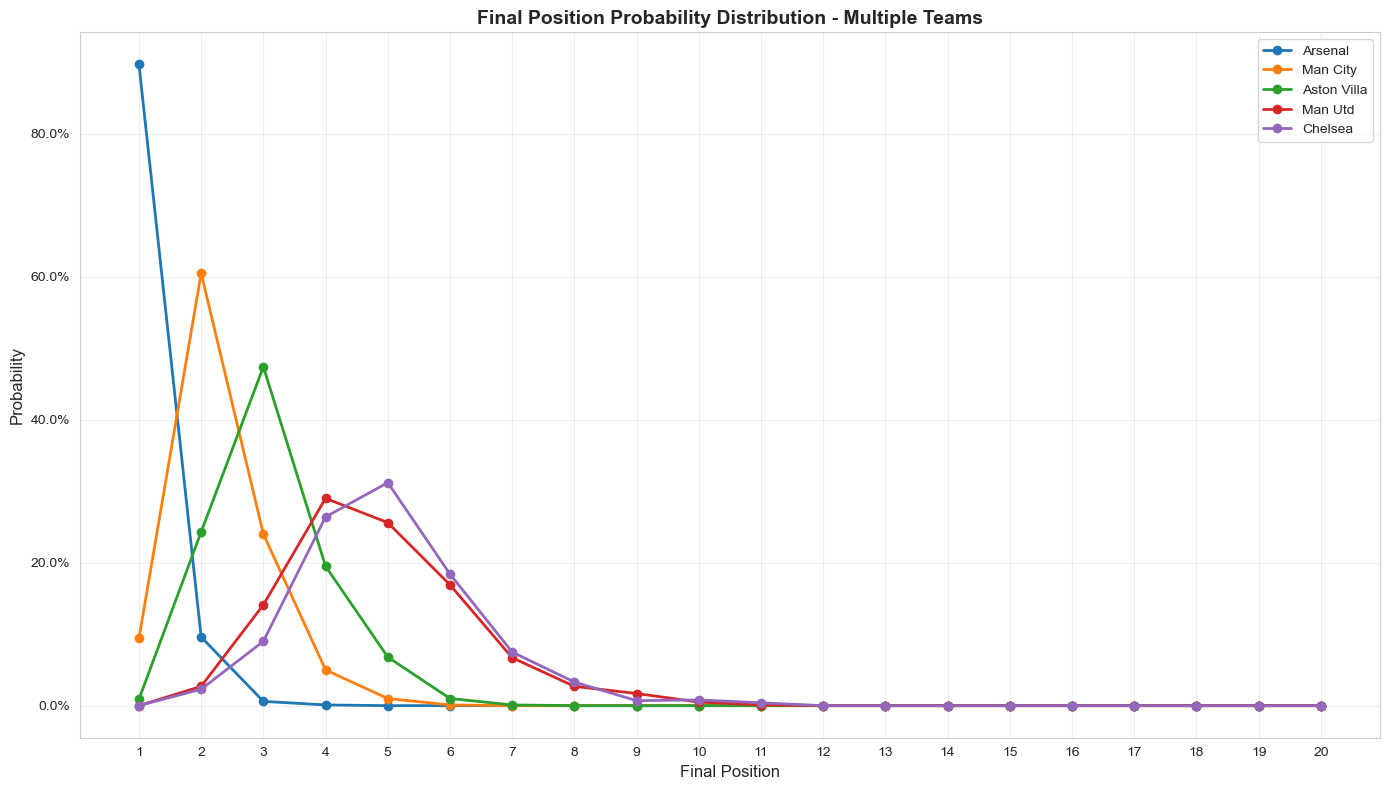

In [13]:
# Analyze top 5 teams
top_5_teams = current_league_table.head(5)["Team"].tolist()

plot_multiple_teams_distribution(position_probs, top_5_teams)

## 9. Summary and Conclusions

Key findings from the Monte Carlo simulation.

In [14]:
# Summary statistics
print(f"League: {config['league']['name']}")
print(f"Season: {config['league']['current_season']}")
print(f"Monte Carlo Simulations: {n_simulations}")
print()

print("Championship Probabilities (Top 3):")
for i, team in enumerate(stats_df.head(3).index, 1):
    prob = position_probs.loc[team, 1]
    print(f"{i}. {team}: {prob:.2%}")

print("\nRelegation Zone Probabilities (Bottom 3):")
n_positions = len(position_probs.columns)
for team in stats_df.tail(3).index:
    prob_bottom_3 = position_probs.loc[team, n_positions - 2 : n_positions].sum()
    print(f"{team}: {prob_bottom_3:.2%}")

League: English Premier League
Season: 2025
Monte Carlo Simulations: 1000

Championship Probabilities (Top 3):
1. Arsenal: 89.70%
2. Man City: 9.40%
3. Aston Villa: 0.90%

Relegation Zone Probabilities (Bottom 3):
West Ham: 93.30%
Burnley: 99.80%
Wolves: 100.00%
